<a href="https://colab.research.google.com/github/sobti/TSAI/blob/master/S15/Copy_of_Unet_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torchvision
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from albumentations.pytorch import ToTensor
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from google.colab import drive
import os
import sys
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from pathlib import Path
import torchvision
import torch
import albumentations
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose,Cutout)

drive.mount('/content/gdrive/')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/resnet/YoloV3\DenseDepth')
os.chdir('/content/gdrive/My Drive/Colab Notebooks/resnet/YoloV3/DenseDepth')

In [0]:
import torch.nn as nn
import torch.nn.functional as F


dropout_value=0.02
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()

       
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size=(3,3),bias=False,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32)
    
        )
        self.pool1 = nn.MaxPool2d(2, 2)

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(3,3),bias=False,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
    
        )
        self.pool2 = nn.MaxPool2d(2, 2)

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(3,3),bias=False,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
    
        )
        self.pool3 = nn.MaxPool2d(2, 2)

        self.centerlayer = nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=256, kernel_size=(3,3),bias=False,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout(),
            nn.ConvTranspose2d(256, 128, 2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )

#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
         
         #concat here ---torch.cat([centerlayer, F.upsample_bilinear(convblock4, centerlayer.size()[2:])], 1)) 

        
         
        self.upsmaple1 = nn.Sequential(
            nn.Conv2d(in_channels=256,out_channels=128, kernel_size=(3,3),bias=False,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(64)
            )
        
         #concat here---torch.cat([upsample2, F.upsample_bilinear(convblock2, upsample2.size()[2:])], 1))
        
        self.upsmaple2 = nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=64, kernel_size=(3,3),bias=False,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, 2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32))
          
         # concat -- here --torch.cat([upsample2, F.upsample_bilinear(convblock2, upsample2.size()[2:])], 1))

        self.finalconv = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=32, kernel_size=(3,3),bias=False,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=3, kernel_size=(3,3),bias=False,padding=1)
        )
        


####################################Forward pass##########################################


    def forward(self, x):
        #x1=self.feature(x)
        #y1=self.feature(y)
        #res=torch.cat((x1, y1), 1)  
        conv1=self.convblock1(x)
        conv2= self.pool1(conv1)
        conv2 = self.convblock2(conv2)
        conv3 = self.pool1(conv2)
        conv3 = self.convblock3(conv3)
        conv4 = self.pool3(conv3)
        cent = self.centerlayer(conv4)
        #--------------------------------------------------------------------------------------------------------------------
        #mask=self.convcent(cent)
        #---------------------------------------------------------------------------------------------------------------------
        cat1=torch.cat([cent, F.upsample_bilinear(conv3, cent.size()[2:])], 1)
        upsam1=self.upsmaple1(cat1)
        cat2=torch.cat([upsam1, F.upsample_bilinear(conv2, upsam1.size()[2:])], 1)
        upsam2=self.upsmaple2(cat2)
        cat3=torch.cat([upsam2, F.upsample_bilinear(conv1, upsam2.size()[2:])], 1)
        final=self.finalconv(cat3)
        return final
        #return cat1

In [0]:
!pip install torchsummary
import torch
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Unet().to(device)
summary(model,input_size=(1,128,128))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             288
              ReLU-2         [-1, 32, 128, 128]               0
       BatchNorm2d-3         [-1, 32, 128, 128]              64
         MaxPool2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          18,432
              ReLU-6           [-1, 64, 64, 64]               0
       BatchNorm2d-7           [-1, 64, 64, 64]             128
         MaxPool2d-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]          73,728
             ReLU-10          [-1, 128, 32, 32]               0
      BatchNorm2d-11          [-1, 128, 32, 32]             256
        MaxPool2d-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         294,912
             ReLU-14          [-1,

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3104: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


In [0]:
rm -r '/content/data/'

rm: cannot remove '/content/data/': No such file or directory


In [0]:
!7z x '/content/gdrive/My Drive/Colab Notebooks/Dataset/bg.7z' -o'/content/data/bg/'
!7z x '/content/gdrive/My Drive/Colab Notebooks/Dataset/fgbg.7z' -o'/content/data/fgbg/'
!7z x '/content/gdrive/My Drive/Colab Notebooks/Dataset/fgbgmask.7z' -o'/content/data/fgbgmask/'


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/gdrive/My Drive/Colab Notebooks/Dataset/                                                           1 file, 2286969 bytes (2234 KiB)

Extracting archive: /content/gdrive/My Drive/Colab Notebooks/Dataset/bg.7z
--
Path = /content/gdrive/My Drive/Colab Notebooks/Dataset/bg.7z
Type = 7z
Physical Size = 2286969
Headers Size = 1341
Method = LZMA2:3m
Solid = +
Blocks = 1

  0%    Everything is Ok

Files: 100
Size:       2341905
Compressed: 2286969

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50

In [0]:
bg_image_list_final=[]
fgbg_image_list=[]
bg_image_list=[]
mask_image_list=[]

count=1  # to restrict the data to few thousand


# Getting the BG list and replicate each background to 4000 


for root, dirs, files in os.walk("/content/data/bg/"):
   for name in files:
      if count == 15:
       break
      bg_image_list.append(root+name)
      bg_image_list_final=(((bg_image_list)*4000)+bg_image_list_final)
      fgbg_folder=(name.split('.'))[0]
      bg_image_list=[]
      count = count + 1
      

# Getting the fgbg list into Variable for data loader.

      path="/content/data/fgbg/" + fgbg_folder
  
      for root_fgbg, dirs_fgbg, files_fgbg in os.walk(path):
          for name_fgbg in files_fgbg:
             fgbg_image_list.append(root_fgbg +'/'+ name_fgbg)

# Getting the mask list into Variable for data loader.

      path="/content/data/fgbgmask/" + fgbg_folder

      for root_mask, dirs_mask, files_mask in os.walk(path):
          for name_mask in files_mask:
             mask_image_list.append(root_mask +'/'+ name_mask)
 

In [0]:
fgbg_image_dataset=sorted(fgbg_image_list)
bg_image_dataset=sorted(bg_image_list_final)
mask_image_dataset=sorted(mask_image_list)
print('No of data in fgbg list:',   len(fgbg_image_dataset))
print('No of data in bg list:' ,    len(bg_image_dataset))
print('No of image in mask image:', len(mask_image_dataset))

No of data in fgbg list: 56000
No of data in bg list: 56000
No of image in mask image: 56000


In [0]:

fgbg_transform = transforms.Compose([
                                       transforms.Resize((128, 128)),
                                       transforms.ColorJitter(brightness=0.20, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-10,10),fill=(0)),
                                       transforms.Grayscale(),
                                       transforms.ToTensor(),
                                      
                                       #transforms.Normalize((0.49641467,), (0.2798614 ,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

bg_transform = transforms.Compose([
                                       transforms.Resize((128, 128)),
                                       transforms.ColorJitter(brightness=0.20, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-10,10),fill=(0)),
                                       transforms.Grayscale(),
                                       transforms.ToTensor(),
                                       
                                       #transforms.Normalize((0.49836101,), (0.27918635,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])


mask_transform = transforms.Compose([
                                       transforms.Resize((128, 128)),
                                       #transforms.Grayscale(),
                                       #transforms.ColorJitter(brightness=0.20, contrast=0.1, saturation=0.10, hue=0.1),
                                      #transforms.RandomRotation((-10,10),fill=(0,)),
                                       transforms.ToTensor(),
                                       
                                       #transforms.Normalize((0.05250582,), (0.22033702,))
                                       ])

In [0]:
import glob
from PIL import Image
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [0]:
class Myclass(torch.utils.data.Dataset):
    def __init__ (self,bg_image_dataset,fgbg_image_dataset,mask_image_dataset,transform=None):
       #super(depthmask, self).__init__()
       self.bg_image_dataset = bg_image_dataset
       
       self.fgbg_image_dataset = fgbg_image_dataset
       self.mask_image_dataset = mask_image_dataset
       self.transform = transform
       

    def __getitem__ (self, idx): 
         bg = Image.open(self.bg_image_dataset[idx])
         fgbg = Image.open(self.fgbg_image_dataset[idx])
         mask = Image.open(self.mask_image_dataset[idx])
         if self.transform:
           bg = self.transform[1](bg)
           fgbg = self.transform[0](fgbg)
           mask = self.transform[2](mask)
           sample = {'bg' : bg, 'fgbg': fgbg, 'mask': mask}
         return sample
    
    def __len__ (self):
       return len(self.fgbg_image_dataset)
  

In [0]:
final_dataset=Myclass(bg_image_dataset,fgbg_image_dataset,mask_image_dataset,transform=[fgbg_transform,bg_transform,mask_transform])
for i in range(len(final_dataset)):
    sample = final_dataset[i]
    print(i,'-BG:', sample['bg'].size(),'-FGBG:' ,sample['fgbg'].size(),'-Mask' ,sample['mask'].size())

    if i == 3:
        break

0 -BG: torch.Size([1, 128, 128]) -FGBG: torch.Size([1, 128, 128]) -Mask torch.Size([3, 128, 128])
1 -BG: torch.Size([1, 128, 128]) -FGBG: torch.Size([1, 128, 128]) -Mask torch.Size([3, 128, 128])
2 -BG: torch.Size([1, 128, 128]) -FGBG: torch.Size([1, 128, 128]) -Mask torch.Size([3, 128, 128])
3 -BG: torch.Size([1, 128, 128]) -FGBG: torch.Size([1, 128, 128]) -Mask torch.Size([3, 128, 128])


In [0]:
SEED = 1
torch.cuda.empty_cache()
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
torch.manual_seed(SEED)
if cuda:
  torch.cuda.manual_seed(SEED) 

train_dataset, valid_dataset = torch.utils.data.random_split(final_dataset, (45000, 11000))

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=16,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(valid_dataset, batch_size=16,
                                         shuffle=False, num_workers=2)

CUDA Available? True


In [0]:
img=next(iter(trainloader))

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  cri = nn.BCEWithLogitsLoss()
  for batch_idx, data in enumerate(pbar):
    # get samples
    data['bg'] = data['bg'].to(device)
    data['fgbg'] = data['fgbg'].to(device)
    data['mask'] = data['mask'].to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    #y_pred,y_pred1 = model(data['bg'],data['fgbg'])
    y_pred = model(data['fgbg'])
   
    # Calculate loss
    
    loss=cri(y_pred,data['mask'])
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    #pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    #correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)
    
    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx}')
    #train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    map=[]
    test_loss = 0
    correct = 0
    cri = nn.BCEWithLogitsLoss()
    with torch.no_grad():
        for data in test_loader:
            data['bg'] = data['bg'].to(device)
            data['fgbg'] = data['fgbg'].to(device)
            data['mask'] = data['mask'].to(device)

            output = model(data['fgbg'])
            test_loss += cri(data['mask'], output).item()  # sum up batch loss
#            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#            correct += pred.eq(target.view_as(pred)).sum().item()
    
    
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))
    
#        100. * correct / len(test_loader.dataset)))
    
#    test_acc.append(100. * correct / len(test_loader.dataset))
  
   

In [0]:
from torch.optim.lr_scheduler import StepLR
optimizer = optim.SGD(model.parameters(), lr=0.046, momentum=0.90,weight_decay=0.001)
scheduler=StepLR(optimizer,step_size=2,gamma=0.1)
#optimizer=optim.Adam(model.parameters(), lr=0.055, betas=(0.9, 0.999), eps=1e-08, amsgrad=False)

EPOCHS = 5
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, trainloader, optimizer, epoch)
    test(model, device, testloader)
    scheduler.step()

  0%|          | 0/2813 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3104: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
  0%|          | 0/2813 [00:00<?, ?it/s]


Test set: Average loss: 0.0273

EPOCH: 1


  0%|          | 0/2813 [00:00<?, ?it/s]


Test set: Average loss: 0.0320

EPOCH: 2


  0%|          | 0/2813 [00:00<?, ?it/s]


Test set: Average loss: 0.0217

EPOCH: 3


  0%|          | 0/2813 [00:00<?, ?it/s]


Test set: Average loss: 0.0187

EPOCH: 4


Loss=0.5159353017807007 Batch_id=2812: 100%|██████████| 2813/2813 [06:56<00:00,  6.75it/s]



Test set: Average loss: 0.0196



In [0]:
data=(next(iter(testloader)))
out=model(data['fgbg'].to(device))
data1=(next(iter(trainloader)))

out[7]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3104: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


tensor([[[ 0.6977,  0.8146,  0.6374,  ...,  0.0134,  0.0451,  0.1054],
         [ 0.7550,  0.7352,  0.4688,  ..., -0.0498, -0.0298,  0.0321],
         [ 0.6406,  0.5434,  0.3130,  ...,  0.1417,  0.0577,  0.0160],
         ...,
         [-0.6608, -0.9024, -1.0513,  ..., -0.0946, -0.2564, -0.2766],
         [-1.1350, -1.6290, -1.8097,  ..., -0.0717, -0.2711, -0.3035],
         [-1.0423, -1.5127, -1.6097,  ..., -0.0533, -0.2106, -0.2306]],

        [[ 0.9410,  1.2025,  1.0644,  ...,  0.7634,  0.7655,  0.6073],
         [ 1.0624,  1.2078,  0.9563,  ...,  0.8626,  0.8932,  0.6944],
         [ 1.0070,  1.0798,  0.8226,  ...,  0.9951,  0.9513,  0.6666],
         ...,
         [-0.4851, -0.6056, -0.7571,  ..., -0.1148, -0.2656, -0.2905],
         [-0.9854, -1.3963, -1.5874,  ..., -0.0270, -0.2285, -0.2911],
         [-0.9601, -1.3911, -1.4961,  ..., -0.0111, -0.1683, -0.2101]],

        [[ 1.1990,  1.5636,  1.5537,  ...,  1.6957,  1.7270,  1.2625],
         [ 1.3440,  1.5768,  1.4517,  ...,  2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


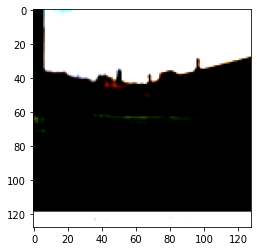

In [0]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(np.transpose((out[6]).cpu().detach().numpy(), (1,2, 0)))

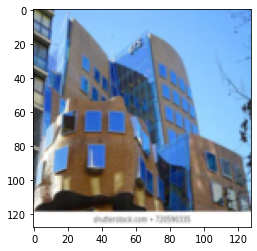

In [0]:
data1['mask'][1]
plt.imshow(np.transpose((data1['mask'][6]).cpu().detach().numpy(), (1,2,0)))

In [0]:
##################ROUGH CODE To ACHIVE DEPTH MAP#################################################
unet = Unet(in_channel=1,out_channel=2)
#out_channel represents number of segments desired
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(unet.parameters(), lr = 0.01, momentum=0.99)
optimizer.zero_grad()       
outputs = unet(inputs)
# permute such that number of desired segments would be on 4th dimension
outputs = outputs.permute(0, 2, 3, 1)
m = outputs.shape[0]
# Resizing the outputs and label to caculate pixel wise softmax loss
outputs = outputs.resize(m*width_out*height_out, 2)
labels = labels.resize(m*width_out*height_out)
loss = criterion(outputs, labels)
loss.backward()
optimizer.step()